## Developing a RnnModel with darts package

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import ta

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import ExponentialSmoothing, RNNModel


/home/mehmet/.pyenv/versions/assist_trader/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Import data
df= pd.read_csv("../raw_data/20230609-165037-processed-data.csv")
df

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [ ]:
df.info()

In [ ]:
freq = '1h'
target_col = 'close'
time_col = 'timestamp'
series = TimeSeries.from_dataframe(df, time_col=time_col, value_cols=[target_col], freq=freq)

In [ ]:
type(series[0])

In [ ]:
train, val = series.split_after(pd.Timestamp('2023-01-01'))

In [ ]:
train

In [ ]:
model = RNNModel(model="LSTM", hidden_dim=20, batch_size=32, n_epochs=50, input_chunk_length=1)

In [ ]:
model.fit(train)

In [ ]:
prediction = model.predict(len(val))

In [ ]:
# scaler = RobustScaler()
# scaler.fit(series)
# # Apply the scaling transformation to the time series
# scaled_series = series.univariate_values().apply(lambda x: scaler.transform(x.reshape(1, -1)).flatten())

In [ ]:
series.plot(label='actual')
prediction.plot(label='forecast', lw=2)
plt.legend()
plt.xlabel('Hour')
plt.show

### Hourly data

In [2]:
data = pd.read_csv("../raw_data/20230609-170514-daily-processed-data.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1362 entries, 0 to 1361
Data columns (total 61 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   timestamp                   1362 non-null   object 
 1   open                        1362 non-null   float64
 2   high                        1362 non-null   float64
 3   low                         1362 non-null   float64
 4   close                       1362 non-null   float64
 5   volume                      1362 non-null   float64
 6   volume_CMF                  1362 non-null   float64
 7   volume_FII                  1362 non-null   float64
 8   volume_MFI                  1362 non-null   float64
 9   volume_VWA                  1362 non-null   float64
 10  mom_AOI                     1362 non-null   float64
 11  mom_PPO                     1362 non-null   float64
 12  mom_PPO_signal              1362 non-null   float64
 13  mom_PVO                     1362 

In [4]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1362 entries, 0 to 1361
Data columns (total 61 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   timestamp                   1362 non-null   datetime64[ns]
 1   open                        1362 non-null   float64       
 2   high                        1362 non-null   float64       
 3   low                         1362 non-null   float64       
 4   close                       1362 non-null   float64       
 5   volume                      1362 non-null   float64       
 6   volume_CMF                  1362 non-null   float64       
 7   volume_FII                  1362 non-null   float64       
 8   volume_MFI                  1362 non-null   float64       
 9   volume_VWA                  1362 non-null   float64       
 10  mom_AOI                     1362 non-null   float64       
 11  mom_PPO                     1362 non-null   float64     

In [6]:
freq = '1d'
target_col = 'close'
time_col = 'timestamp'
series = TimeSeries.from_dataframe(data, time_col=time_col, value_cols=[target_col], freq=freq)

In [7]:
train, val = series.split_after(pd.Timestamp('2023-01-01'))

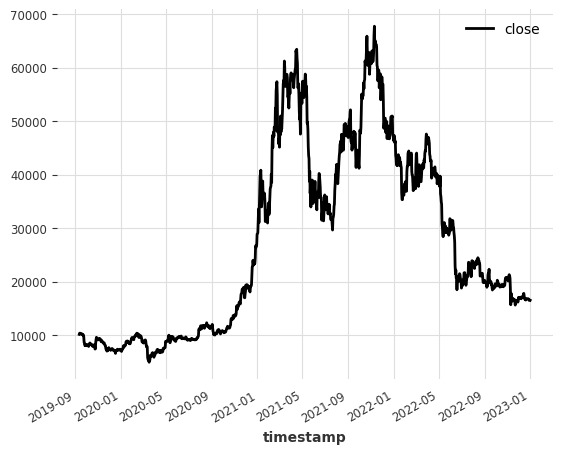

In [15]:
train.plot()

In [22]:
model = RNNModel(model="LSTM", n_rnn_layers=8, hidden_dim=20, batch_size=32, n_epochs=20, input_chunk_length=21, training_length=1)

In [23]:
model.fit(train)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 25.4 K
4 | V             | Linear           | 21    
---------------------------------------------------
25.4 K    Trainable params
0         Non-trainable

Epoch 19: 100%|████████████████████████████████████████████████████| 38/38 [00:00<00:00, 113.73it/s, train_loss=1.43e+9]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|████████████████████████████████████████████████████| 38/38 [00:00<00:00, 113.17it/s, train_loss=1.43e+9]


RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=8, dropout=0.0, training_length=1, batch_size=32, n_epochs=20, input_chunk_length=21)

In [16]:
val

<TimeSeries (DataArray) (timestamp: 154, component: 1, sample: 1)>
array([[[16597.6]],

       [[16751.9]],

       [[16658.8]],

       [[16819.4]],

       [[16840. ]],

       [[16922.9]],

       [[16931.5]],

       [[16949.2]],

       [[17172.5]],

       [[17453.6]],

...

       [[26465.9]],

       [[26711.4]],

       [[26759.4]],

       [[27828.5]],

       [[27653.4]],

       [[27710.1]],

       [[27081.9]],

       [[26881.4]],

       [[27190. ]],

       [[26990. ]]])
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 2023-01-02 2023-01-03 ... 2023-06-04
  * component  (component) object 'close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [28]:
prediction = model.predict(21)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.35it/s]


In [29]:
prediction

<TimeSeries (DataArray) (timestamp: 21, component: 1, sample: 1)>
array([[[20.48098005]],

       [[20.48099464]],

       [[20.48100527]],

       [[20.48101309]],

       [[20.48101889]],

       [[20.48102323]],

       [[20.48102648]],

       [[20.48102895]],

       [[20.48103082]],

       [[20.48103225]],

...

       [[20.4810342 ]],

       [[20.48103485]],

       [[20.48103536]],

       [[20.48103575]],

       [[20.48103606]],

       [[20.4810363 ]],

       [[20.48103649]],

       [[20.48103663]],

       [[20.48103675]],

       [[20.48103684]]])
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 2023-01-02 2023-01-03 ... 2023-01-22
  * component  (component) object 'close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
backtest = model.historical_forecasts(series, start=0.8, forecast_horizon=1)

In [ ]:
series[1000:].plot()
backtest.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [ ]:
series.plot(label='actual')
prediction.plot(label='forecast', lw=2)
plt.legend()
plt.xlabel('Day')
plt.show